## Adaptive Resonance Theory
Feedback mechanism + Competitive-learning scheme
#### ART1

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.datasets import mnist
import numpy as np

#### 讀取 MNIST
see https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py

In [4]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
_, img_rows, img_cols = x_train.shape
print ('原始 shape = (資料數目, #row, #col)')
print ('#train = ', x_train.shape[0], ', #test = ', x_test.shape[0])
print ('image rows = ', img_rows, ', image_cols = ', img_cols)
# flatten
x_train = np.reshape(x_train, (x_train.shape[0], img_rows*img_cols))
x_test = np.reshape(x_test, (x_test.shape[0], img_rows*img_cols))
print ('image map 轉 vector')
print ('new x_train.shape = ', x_train.shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

原始 shape = (資料數目, #row, #col)
#train =  60000 , #test =  10000
image rows =  28 , image_cols =  28
image map 轉 vector
new x_train.shape =  (60000, 784)


因為ART1只適用於"binary patterns"，將圖檔轉為binary image
$\left[0,255\right] \rightarrow \left[0,1\right]$

In [5]:
def Convert2Binary(x, thre = 128):
    idx = x[:,:] < thre
    x[idx] = 0
    idx = x[:,:] > 0
    x[idx] = 1
    return x

x_train = Convert2Binary(x_train, 1)
x_test = Convert2Binary(x_test, 1)

#### A. Preparation
1. Determin $F_1$ and $F_2$ nodes: $dim(F_1, F_2) = (M,N)$
2. Determin parameter values: $A_1\geq 0,~C_1\geq 0,~P_1\geq 0,~L>1$
  * $A$: Orienting subsystem, (1 reset node)

In [6]:
class ART1(object):
    def __init__(self, M = 5, N = 6, L = 3.0, rho = 0.9, A = 1.0, B = 1.5, C = 5.0, D=0.9):
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        self.L = L
        self.rho = rho
        # activites
        self.X1 = np.ones(M) * (-B / (1.0 + C))
        self.X2 = np.zeros(N)
        # TopDown weights
        self.Zi = np.ones((N, M)) * ((B-1.0)/D + 0.2)
        self.Zj = np.ones((M, N)) * (L/(L-1.0+M) - 0.1)
        self.commited = 0
        self.counter = 0;
        self.time_stamps = np.zeros(N)
    
    def OutputF1(self):
        S = np.zeros_like(self.X1)
        positive_idx = self.X1[:] > 0
        S[positive_idx] = 1
        return S
    
    def OutputF2(self, T):
        winner = np.argmax(T)
        U = np.zeros_like(T)
        U[winner] = 1
        return U, winner
    
    def StorePattern(self, winner, I):
        self.Zj[:, winner] = I
        self.Zi[winner, :] = I
        self.time_stamps[winner] = self.counter
        return
    
    def Processing(self, I):
        self.counter += 1
        self.X1 = np.divide(I, (1.0 + self.A*(I+self.B)+self.C))
        # S = F1 output
        S = self.OutputF1()
        # T = F2 input
        T = np.dot(self.Zj[:,:self.commited].transpose(), S)
        while T.size > 0 and np.amax(T) > float('-inf'):
            # U = F2 winner
            U, winner = self.OutputF2(T)
            # V = F1 input from F2
            V = np.dot(self.Zi[:self.commited,:].transpose(), U)
            # F1 activity
            self.X1 = np.divide(I + (self.D*V) - self.B, 1 + self.A * (I + self.D*V) + self.C)
            S = self.OutputF1()
            # reset?
            A = (np.sum(S) * 1.0 / np.sum(I)) < self.rho
            if A:
                # mark winner neuron as inactive
                T[winner] = float('-inf')
            else:
                # matched
                # update BU weights
                self.Zj[:,winner] = 0
                self.Zj[:,winner][self.X1 > 0] = self.L / self.L - 1.0 + np.sum(S)
                # update TD weights
                self.Zi[winner,:] = 0
                self.Zi[winner,:][self.X1 > 0] = 1.0
                #
                self.time_stamps[winner] = self.counter
                return winner
        
        # no match
        if self.commited < self.Zi.shape[0]:
            # available uncommited nodes
            # store new pattern
            winner = self.commited
            self.StorePattern(winner, I)
            self.commited += 1
            return winner
        
        # replace a long ignored old pattern with new one
        winner = np.argmin(self.time_stamps)
        self.StorePattern(winner, I)
        # print ('replace a long ignored old pattern with new one')
        return winner


### Feed data

In [97]:
model = ART1(M=x_train.shape[1], N=100, rho=0.6)
idx = np.arange(x_train.shape[0])
np.random.shuffle(idx)
for i in range(x_train.shape[0]):
    model.rho = 0.99999 ** i
    model.Processing(x_train[idx[i],:])

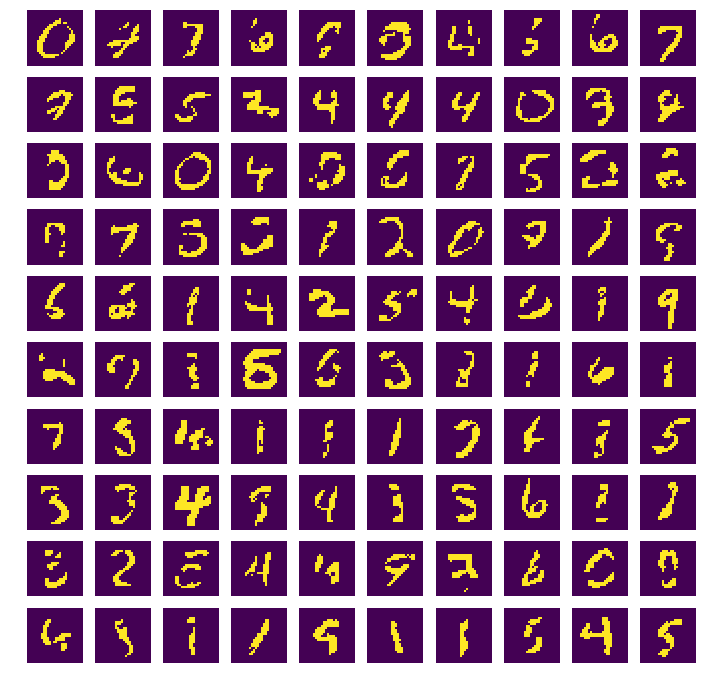

In [101]:
# plot
plt.figure(figsize=(12,12))
for i in range(100):
    plt.subplot(10,10,1 + i)
    plt.axis('off')
    plt.imshow(np.reshape(model.Zi[i,:], (28,28)))


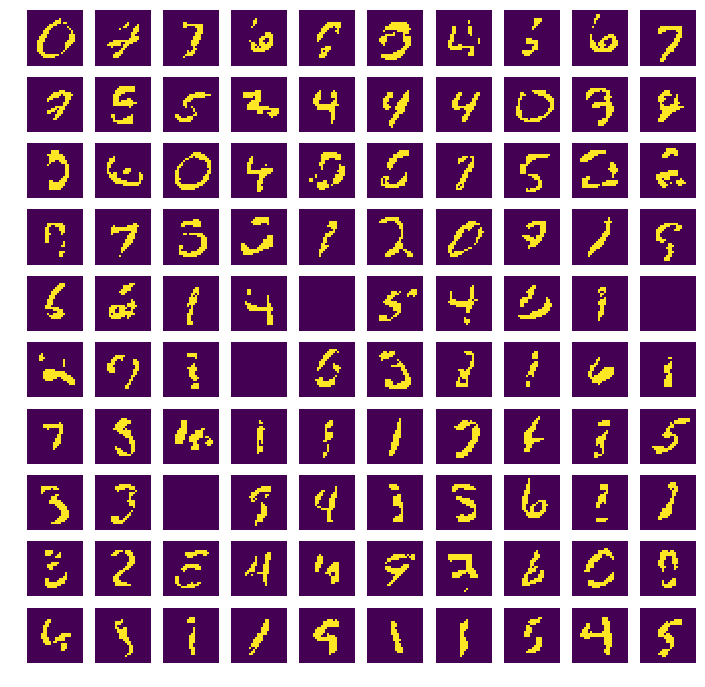

In [103]:
plt.figure(figsize=(12,12))
for i in range(100):
    plt.subplot(10,10,1 + i)
    plt.axis('off')
    plt.imshow(np.reshape(model.Zj[:,i]-model.Zi[i,:], (28,28)))
